<a href="https://colab.research.google.com/github/Sheepybloke2-0/CSE847-Project/blob/main/Model_Training/tinyml_seedling_detect.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
# Check that imports for the rest of the file work.
import tensorflow as tf

!pip install -q imageio
!pip install -q git+https://github.com/tensorflow/docs
!pip install -q kaggle
! pip install -q tensorflow-model-optimization

!apt-get update && apt-get -qq install xxd

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
# Allow matplotlib images to render immediately.
%matplotlib inline

import glob
import imageio
import os
import PIL
from tensorflow.keras import layers
import time
import tensorflow_datasets as tfds
import tensorflow_model_optimization as tfmot
import tempfile

from IPython import display

Ign:1 https://developer.download.nvidia.com/compute/cuda/repos/ubuntu1804/x86_64  InRelease
Hit:2 https://cloud.r-project.org/bin/linux/ubuntu bionic-cran40/ InRelease
Get:3 http://security.ubuntu.com/ubuntu bionic-security InRelease [88.7 kB]
Ign:4 https://developer.download.nvidia.com/compute/machine-learning/repos/ubuntu1804/x86_64  InRelease
Hit:5 https://developer.download.nvidia.com/compute/cuda/repos/ubuntu1804/x86_64  Release
Hit:6 https://developer.download.nvidia.com/compute/machine-learning/repos/ubuntu1804/x86_64  Release
Hit:7 http://ppa.launchpad.net/c2d4u.team/c2d4u4.0+/ubuntu bionic InRelease
Hit:9 http://archive.ubuntu.com/ubuntu bionic InRelease
Hit:11 http://ppa.launchpad.net/cran/libgit2/ubuntu bionic InRelease
Get:12 http://archive.ubuntu.com/ubuntu bionic-updates InRelease [88.7 kB]
Hit:13 http://ppa.launchpad.net/deadsnakes/ppa/ubuntu bionic InRelease
Get:14 http://archive.ubuntu.com/ubuntu bionic-backports InRelease [74.6 kB]
Hit:15 http://ppa.launchpad.net/grap

In [ ]:
from google.colab import drive
drive.mount('/content/gdrive/')

Drive already mounted at /content/gdrive/; to attempt to forcibly remount, call drive.mount("/content/gdrive/", force_remount=True).


In [ ]:
from google.colab import files
import pathlib
kaggleJson = pathlib.Path("/content/.kaggle/kaggle.json")
if not kaggleJson.is_file():
  # files.upload()
  !mkdir -p /content/.kaggle/
  %cd /content/gdrive/My\ Drive/
  !cp ./kaggle.json /content/.kaggle/
  !chmod 600 /content/.kaggle/kaggle.json
%env KAGGLE_CONFIG_DIR=/content/.kaggle
!echo $KAGGLE_CONFIG_DIR
!kaggle config view
!kaggle datasets list

env: KAGGLE_CONFIG_DIR=/content/.kaggle
/content/.kaggle
Configuration values from /content/.kaggle
- username: reubenlewis
- path: None
- proxy: None
- competition: None
ref                                                         title                                              size  lastUpdated          downloadCount  
----------------------------------------------------------  ------------------------------------------------  -----  -------------------  -------------  
gpreda/reddit-vaccine-myths                                 Reddit Vaccine Myths                              223KB  2021-04-17 19:10:49           3061  
crowww/a-large-scale-fish-dataset                           A Large Scale Fish Dataset                          3GB  2021-02-17 16:10:44           1794  
dhruvildave/wikibooks-dataset                               Wikibooks Dataset                                   1GB  2021-02-18 10:08:27           1227  
promptcloud/careerbuilder-job-listing-2020                 

In [ ]:
# NOTE: Remove the zip file and redownload if the unzip isn't working properly
imageZip = pathlib.Path('/content/gdrive/My Drive/v2-plant-seedlings-dataset.zip')
if not imageZip.is_file():
  !kaggle datasets download -d vbookshelf/v2-plant-seedlings-dataset
  !ls
else:
  %cd /content/gdrive/My\ Drive/
!unzip v2-plant-seedlings-dataset.zip -d /content/

Streaming output truncated to the last 5000 lines.
  inflating: /content/nonsegmentedv2/Charlock/308.png  
  inflating: /content/nonsegmentedv2/Charlock/309.png  
  inflating: /content/nonsegmentedv2/Charlock/31.png  
  inflating: /content/nonsegmentedv2/Charlock/310.png  
  inflating: /content/nonsegmentedv2/Charlock/311.png  
  inflating: /content/nonsegmentedv2/Charlock/312.png  
  inflating: /content/nonsegmentedv2/Charlock/313.png  
  inflating: /content/nonsegmentedv2/Charlock/314.png  
  inflating: /content/nonsegmentedv2/Charlock/315.png  
  inflating: /content/nonsegmentedv2/Charlock/316.png  
  inflating: /content/nonsegmentedv2/Charlock/317.png  
  inflating: /content/nonsegmentedv2/Charlock/318.png  
  inflating: /content/nonsegmentedv2/Charlock/319.png  
  inflating: /content/nonsegmentedv2/Charlock/32.png  
  inflating: /content/nonsegmentedv2/Charlock/320.png  
  inflating: /content/nonsegmentedv2/Charlock/321.png  
  inflating: /content/nonsegmentedv2/Charlock/322.png  

In [ ]:
rootDir = pathlib.Path('/content/')
%cd /content/
!rm -r sample_data

imageCount = len(list(rootDir.glob('nonsegmentedv2/*/*.png')))
print(imageCount)

/content
rm: cannot remove 'sample_data': No such file or directory
5539


In [ ]:
# CONSTANTS GO HERE
BUFFER_SIZE = imageCount
BATCH_SIZE = 32
IM_SIZE = (64, 64)
IM_DIMS = (64, 64,3)
EPOCHS = 150
FULL_MODEL = '/content/gdrive/My Drive/full_model'
LITE_MODEL = '/content/gdrive/My Drive/lite_model.tflite'
LITE_MODEL_ESC = '/content/gdrive/My\ Drive/lite_model.tflite'
QUANT_MODEL = '/content/gdrive/My Drive/quant_model.tflite'
QUANT_MODEL_ESC = '/content/gdrive/My\ Drive/quant_model.tflite'
MICRO_MODEL = '/content/gdrive/My Drive/micro_model.cc'
MICRO_MODEL_ESC = '/content/gdrive/My\ Drive/micro_model.cc'

In [ ]:
trainPath = os.path.join(rootDir, 'nonsegmentedv2')

trainDataGen = tf.keras.preprocessing.image.ImageDataGenerator(
        rescale=1./255,
        shear_range=0.1,
        rotation_range=0.1,
        horizontal_flip=True,
        vertical_flip=True,
        validation_split=0.2,
        )

testDataGen = tf.keras.preprocessing.image.ImageDataGenerator(rescale=1./255, validation_split=0.2)

trainGenerator = trainDataGen.flow_from_directory(
    trainPath,
    target_size=IM_SIZE,
    batch_size=BATCH_SIZE,
    subset='training'
    # class_mode="sparse"
)

testGenerator = testDataGen.flow_from_directory(
    trainPath,
    target_size=IM_SIZE,
    batch_size=BATCH_SIZE,
    subset='validation',
    shuffle=False
)


Found 4437 images belonging to 12 classes.
Found 1102 images belonging to 12 classes.


In [ ]:
def classificationModel(numClasses):
  L2_lambda = 0.01

  model = tf.keras.Sequential()
  model.add(layers.Conv2D(16, (3,3), activation='relu', input_shape=IM_DIMS, kernel_regularizer=tf.keras.regularizers.l2(L2_lambda)))
  model.add(layers.BatchNormalization())
  model.add(layers.MaxPooling2D((2,2)))

  model.add(layers.Conv2D(32, (3,3), activation='relu', kernel_regularizer=tf.keras.regularizers.l2(L2_lambda)))
  model.add(layers.BatchNormalization())
  model.add(layers.MaxPooling2D((2,2)))

  model.add(layers.Conv2D(64, (3,3), activation='relu', kernel_regularizer=tf.keras.regularizers.l2(L2_lambda)))
  model.add(layers.BatchNormalization())

  model.add(layers.Conv2D(128, (3,3), activation='relu', kernel_regularizer=tf.keras.regularizers.l2(L2_lambda)))
  model.add(layers.BatchNormalization())

  model.add(layers.Dropout(0.2))
  model.add(layers.Flatten())
  model.add(layers.Dense(16, activation='relu', kernel_regularizer=tf.keras.regularizers.l2(L2_lambda)))
  model.add(layers.Dense(numClasses, kernel_regularizer=tf.keras.regularizers.l2(L2_lambda)))

  model.summary()
  return model

In [ ]:
model = classificationModel(trainGenerator.num_classes)

schedule = tf.keras.optimizers.schedules.ExponentialDecay(0.0001, 100000, 0.98)
opt = tf.keras.optimizers.Adam(learning_rate=schedule)

model.compile(optimizer=opt, loss=tf.keras.losses.CategoricalCrossentropy(from_logits=True), metrics=['accuracy'])

model.fit(
    trainGenerator, 
    validation_data=testGenerator, 
    epochs=EPOCHS,
    steps_per_epoch=trainGenerator.n//trainGenerator.batch_size,
    validation_steps=testGenerator.n//testGenerator.batch_size
    )

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 62, 62, 16)        448       
_________________________________________________________________
batch_normalization (BatchNo (None, 62, 62, 16)        64        
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 31, 31, 16)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 29, 29, 32)        4640      
_________________________________________________________________
batch_normalization_1 (Batch (None, 29, 29, 32)        128       
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 14, 14, 32)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 12, 12, 64)        1

In [ ]:
score = model.evaluate(testGenerator, verbose=0)
print('Test loss:', score[0])
print('Test accuracy:', score[1])

_, keras_file = tempfile.mkstemp('.h5')
tf.keras.models.save_model(model, keras_file, include_optimizer=False)
print('Saved baseline model to:', keras_file)

In [ ]:
loaded_model = tf.keras.models.load_model(FULL_MODEL)

# From https://www.tensorflow.org/model_optimization/guide/pruning/comprehensive_guide.md
def apply_pruning_to_dense(layer):
  if isinstance(layer, tf.keras.layers.Dense):
    return tfmot.sparsity.keras.prune_low_magnitude(layer, **pruning_params)
  if isinstance(layer, tf.keras.layers.Conv2D):
    return tfmot.sparsity.keras.prune_low_magnitude(layer, **pruning_params)
  return layer

# Finish pruning after 50 epochs
pruning_epochs = 50
end_step = np.ceil(4432 / BATCH_SIZE).astype(np.int32) * pruning_epochs

# Define pruning configuration
pruning_params = {
      'pruning_schedule': tfmot.sparsity.keras.PolynomialDecay(initial_sparsity=0.50,
                                                               final_sparsity=0.90,
                                                               begin_step=0,
                                                               end_step=end_step,
                                                               frequency=100)
}
# model_for_pruning = tfmot.sparsity.keras.prune_low_magnitude(dense_layers, )

model_for_pruning = tf.keras.models.clone_model(
    loaded_model,
    clone_function=apply_pruning_to_dense,
)


model_for_pruning.summary()

# Recompile the model
model_for_pruning.compile(loss=tf.keras.losses.CategoricalCrossentropy(from_logits=True),
              optimizer=tf.keras.optimizers.Adam(),
              metrics=['accuracy'])

/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/engine/base_layer.py:2281: UserWarning: `layer.add_variable` is deprecated and will be removed in a future version. Please use `layer.add_weight` method instead.
  warnings.warn('`layer.add_variable` is deprecated and '


Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
sequential_2 (Sequential)    (None, 128, 128, 3)       0         
_________________________________________________________________
rescaling_1 (Rescaling)      (None, 128, 128, 3)       0         
_________________________________________________________________
prune_low_magnitude_conv2d_4 (None, 126, 126, 16)      882       
_________________________________________________________________
batch_normalization_4 (Batch (None, 126, 126, 16)      64        
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 63, 63, 16)        0         
_________________________________________________________________
prune_low_magnitude_conv2d_5 (None, 61, 61, 32)        9250      
_________________________________________________________________
batch_normalization_5 (Batch (None, 61, 61, 32)       

In [ ]:
# Model callbacks
callbacks = [
  tfmot.sparsity.keras.UpdatePruningStep()
]

# Fitting data
model_for_pruning.fit(trainGenerator, 
                      validation_data=testGenerator,
                      steps_per_epoch=trainGenerator.n//trainGenerator.batch_size,
                      validation_steps=testGenerator.n//testGenerator.batch_size,
                      batch_size=BATCH_SIZE,
                      epochs=pruning_epochs,
                      verbose=1,
                      callbacks=callbacks)

Epoch 1/50


In [ ]:
score = model_for_pruning.evaluate(testGenerator, verbose=0)
print('Test loss:', score[0])
print('Test accuracy:', score[1])

Test loss: 0.7695863246917725
Test accuracy: 0.8448275923728943


In [ ]:
model_for_export = tfmot.sparsity.keras.strip_pruning(model_for_pruning)

print("final model")
model_for_export.summary()

model_for_export.compile(loss=tf.keras.losses.CategoricalCrossentropy(from_logits=True),
              optimizer=tf.keras.optimizers.Adam(),
              metrics=['accuracy'])
score = model_for_export.evaluate(testGenerator, verbose=0)
print('Test loss:', score[0])
print('Test accuracy:', score[1])

_, pruned_keras_file = tempfile.mkstemp('.h5')
tf.keras.models.save_model(model_for_export, pruned_keras_file, include_optimizer=False)
print('Saved baseline model to:', pruned_keras_file)

percentages = tf.keras.models.load_model(pruned_keras_file)
for i, w in enumerate(percentages.get_weights()):
    print(
        "{} -- Total:{}, Zeros: {:.2f}%".format(
            percentages.weights[i].name, w.size, np.sum(w == 0) / w.size * 100
        )
    )

final model
Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 62, 62, 16)        448       
_________________________________________________________________
batch_normalization (BatchNo (None, 62, 62, 16)        64        
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 31, 31, 16)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 29, 29, 32)        4640      
_________________________________________________________________
batch_normalization_1 (Batch (None, 29, 29, 32)        128       
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 14, 14, 32)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 12, 12, 

In [ ]:
import zipfile
_, zip3 = tempfile.mkstemp(".zip")
with zipfile.ZipFile(zip3, "w", compression=zipfile.ZIP_DEFLATED) as f:
    f.write(pruned_keras_file)
print(
    "Size of the pruned model before compression: %.2f Mb"
    % (os.path.getsize(pruned_keras_file) / float(2 ** 20))
)
print(
    "Size of the pruned model after compression: %.2f Mb"
    % (os.path.getsize(zip3) / float(2 ** 20))
)

Size of the pruned model before compression: 1.20 Mb
Size of the pruned model after compression: 0.23 Mb


In [ ]:
# Convert the model to the TensorFlow Lite format without quantization
converter = tf.lite.TFLiteConverter.from_keras_model(model_for_export)
model_no_quant_tflite = converter.convert()

# Now test with quantazation for int8: 
# https://stackoverflow.com/questions/65902185/tfliteconverter-representative-dataset-from-keras-preprocessing-image-dataset-fr
def representative_dataset():
  for _ in range(10):
    img = trainGenerator.next()
    yield [img[0]]

converter.representative_dataset = representative_dataset
converter.target_spec.supported_ops = [tf.lite.OpsSet.TFLITE_BUILTINS_INT8]
converter.inference_input_type = tf.int8  # or tf.uint8
converter.inference_output_type = tf.int8  # or tf.uint8
model_quant_tflite = converter.convert()

# Save the model to disk
open(LITE_MODEL, "wb").write(model_no_quant_tflite)
open(QUANT_MODEL, "wb").write(model_quant_tflite)

INFO:tensorflow:Assets written to: /tmp/tmp2jgln3dw/assets
INFO:tensorflow:Assets written to: /tmp/tmp9rglsy_9/assets


INFO:tensorflow:Assets written to: /tmp/tmp9rglsy_9/assets


319712

In [ ]:
# Check the size of the model
# Calculate size
# https://stackoverflow.com/questions/1392413/calculating-a-directorys-size-using-python
def get_size(start_path = '.'):
    total_size = 0
    for dirpath, dirnames, filenames in os.walk(start_path):
        for f in filenames:
            fp = os.path.join(dirpath, f)
            # skip if it is symbolic link
            if not os.path.islink(fp):
                total_size += os.path.getsize(fp)

    return total_size

size_tf = get_size(FULL_MODEL)
size_tflite = os.path.getsize(LITE_MODEL)
size_quant = os.path.getsize(QUANT_MODEL)

pd.DataFrame.from_records(
    [["TensorFlow", f"{size_tf} bytes", ""],
     ["TensorFlow Lite", f"{size_tflite} bytes ", f"(reduced by {size_tf - size_tflite} bytes or {(1 - (size_tflite/size_tf))*100}%)"],
     ["TensorFlow Quant Lite", f"{size_quant} bytes ", f"(reduced by {size_tflite - size_quant} bytes or {(1 - (size_quant/size_tflite))*100}%)"]],
     columns=["Model", "Size", ""], index="Model")

,Size,
Model,,
TensorFlow,179164403 bytes,
TensorFlow Lite,1217980 bytes,(reduced by 177946423 bytes or 99.320188620280...
TensorFlow Quant Lite,319712 bytes,(reduced by 898268 bytes or 73.75063629944663%)


In [ ]:
# Convert to a C source file, i.e, a TensorFlow Lite for Microcontrollers model
!xxd -i {QUANT_MODEL_ESC} > {MICRO_MODEL_ESC}
# Update variable names
REPLACE_TEXT = QUANT_MODEL.replace('/', '_').replace('.', '_')
!sed -i 's/'{REPLACE_TEXT}'/g_model/g' {MICRO_MODEL}

sed: -e expression #1, char 20: unterminated `s' command


# Visualization


## Confusion Matrix

In [ ]:
import seaborn as sns

In [ ]:
class_names = [None] * len(trainGenerator.class_indices)
for name, idx in trainGenerator.class_indices.items():
  class_names[idx] = name

class_names

['Black-grass',
 'Charlock',
 'Cleavers',
 'Common Chickweed',
 'Common wheat',
 'Fat Hen',
 'Loose Silky-bent',
 'Maize',
 'Scentless Mayweed',
 'ShepherdтАЩs Purse',
 'Small-flowered Cranesbill',
 'Sugar beet']

In [ ]:
preds = model.predict(testGenerator)
preds = np.argmax(preds, axis=1)

In [ ]:
testGenerator.labels

array([ 0,  0,  0, ..., 11, 11, 11], dtype=int32)

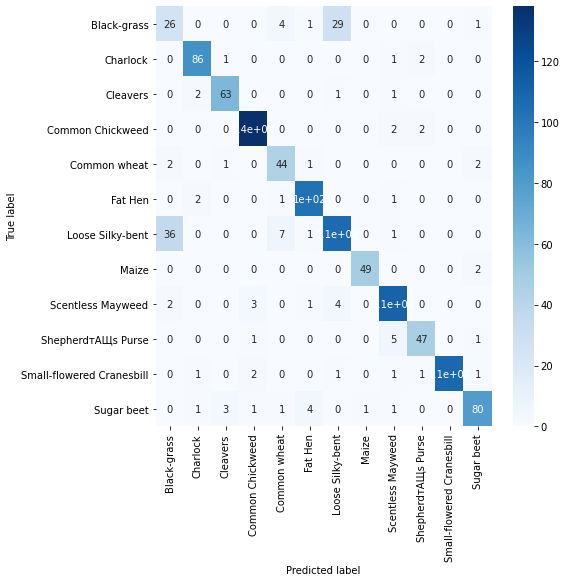

In [ ]:
confusion_mat = tf.math.confusion_matrix(labels=testGenerator.labels, predictions=preds).numpy()
con_mat_df = pd.DataFrame(confusion_mat)

def confusion_matrix_plot(df):
  figure = plt.figure(figsize=(8, 8))
  sns.heatmap(df,
              annot=True,
              cmap=plt.cm.Blues,
              xticklabels=class_names,
              yticklabels=class_names)
  plt.tight_layout()
  plt.ylabel('True label')
  plt.xlabel('Predicted label')
  plt.show()

confusion_matrix_plot(con_mat_df)

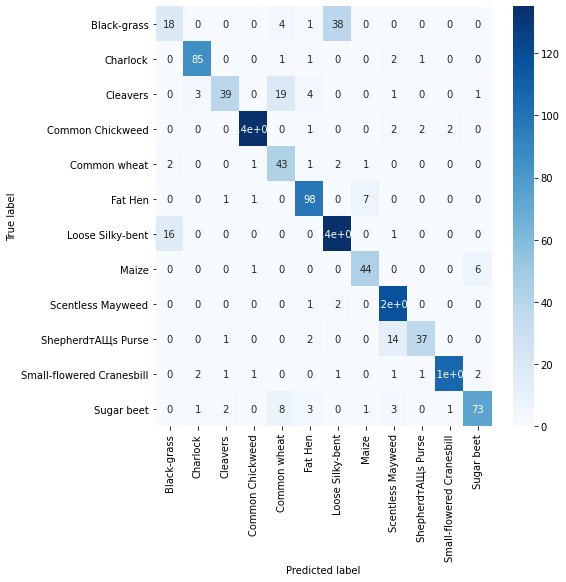

In [ ]:
preds_mp = model_for_pruning.predict(testGenerator)
preds_mp = np.argmax(preds_mp, axis=1)

confusion_mat_mp = tf.math.confusion_matrix(labels=testGenerator.labels, predictions=preds_mp).numpy()
con_mat_df_mp = pd.DataFrame(confusion_mat_mp)

def confusion_matrix_plot(df):
  figure = plt.figure(figsize=(8, 8))
  sns.heatmap(df,
              annot=True,
              cmap=plt.cm.Blues,
              xticklabels=class_names,
              yticklabels=class_names)
  plt.tight_layout()
  plt.ylabel('True label')
  plt.xlabel('Predicted label')
  plt.show()

confusion_matrix_plot(con_mat_df_mp)

In [ ]:
# Helper function to run inference on a TFLite model
def run_tflite_model(tflite_file, test_image_indices, test_images, test_labels):

  # Initialize the interpreter
  interpreter = tf.lite.Interpreter(model_path=str(tflite_file))
  interpreter.allocate_tensors()

  input_details = interpreter.get_input_details()[0]
  output_details = interpreter.get_output_details()[0]

  predictions = np.zeros((len(test_image_indices),), dtype=int)
  for i, test_image_index in enumerate(test_image_indices):
    test_image = test_images[test_image_index]
    test_label = test_labels[test_image_index]

    # Check if the input type is quantized, then rescale input data to uint8
    if input_details['dtype'] == np.int8:
      input_scale, input_zero_point = input_details["quantization"]
      test_image = test_image / input_scale + input_zero_point

    test_image = np.expand_dims(test_image, axis=0).astype(input_details["dtype"])
    interpreter.set_tensor(input_details["index"], test_image)
    interpreter.invoke()
    output = interpreter.get_tensor(output_details["index"])[0]

    predictions[i] = output.argmax()

  return predictions

In [ ]:
def evaluate_model(tflite_file, model_type, test_images, test_labels):

  test_image_indices = range(test_images.shape[0])
  predictions = run_tflite_model(tflite_file, test_image_indices, test_images, test_labels)
  
  accuracy = (np.sum(test_labels== predictions) * 100) / len(test_images)

  print('%s model accuracy is %.4f%% (Number of test samples=%d)' % (
      model_type, accuracy, len(test_images)))
  
  return accuracy, predictions


In [ ]:
testGenerator_sparse = testDataGen.flow_from_directory(
    trainPath,
    target_size=IM_SIZE,
    batch_size=128,
    subset='validation',
    shuffle=False,
    class_mode='sparse'
)

imgs, full_labels = next(iter(testGenerator_sparse))

acc_lite, pred_lite = evaluate_model(LITE_MODEL, "Float", imgs, full_labels)
acc_quant, pred_quant= evaluate_model(QUANT_MODEL, "Qunatization", imgs, full_labels)

for i in range(0, int(1102/128) - 1):
  imgs, labels = next(iter(testGenerator_sparse))

  acc_ret_lite, pred_ret_lite = evaluate_model(LITE_MODEL, "Float", imgs, labels)
  acc_ret_quant, pred_ret_quant= evaluate_model(QUANT_MODEL, "Qunatization", imgs, labels)
  
  acc_lite += acc_ret_lite
  acc_quant += acc_ret_quant
  
  pred_lite = tf.concat([pred_lite, pred_ret_lite], 0)
  pred_quant = tf.concat([pred_quant, pred_ret_quant], 0)
  full_labels = np.concatenate((full_labels, labels))

acc_lite = (acc_lite / int(1102/128))
print("Overall Float accuracy: ", acc_lite )
acc_quant = (acc_quant / int(1102/128))
print("Overall Quantized accuracy: ", acc_quant )


Found 1102 images belonging to 12 classes.
Float model accuracy is 62.5000% (Number of test samples=128)
Qunatization model accuracy is 60.9375% (Number of test samples=128)
Float model accuracy is 76.5625% (Number of test samples=128)
Qunatization model accuracy is 74.2188% (Number of test samples=128)
Float model accuracy is 95.3125% (Number of test samples=128)
Qunatization model accuracy is 95.3125% (Number of test samples=128)
Float model accuracy is 88.2812% (Number of test samples=128)
Qunatization model accuracy is 89.0625% (Number of test samples=128)
Float model accuracy is 89.0625% (Number of test samples=128)
Qunatization model accuracy is 89.8438% (Number of test samples=128)
Float model accuracy is 91.4062% (Number of test samples=128)
Qunatization model accuracy is 90.6250% (Number of test samples=128)
Float model accuracy is 85.1562% (Number of test samples=128)
Qunatization model accuracy is 83.5938% (Number of test samples=128)
Float model accuracy is 89.8438% (Number

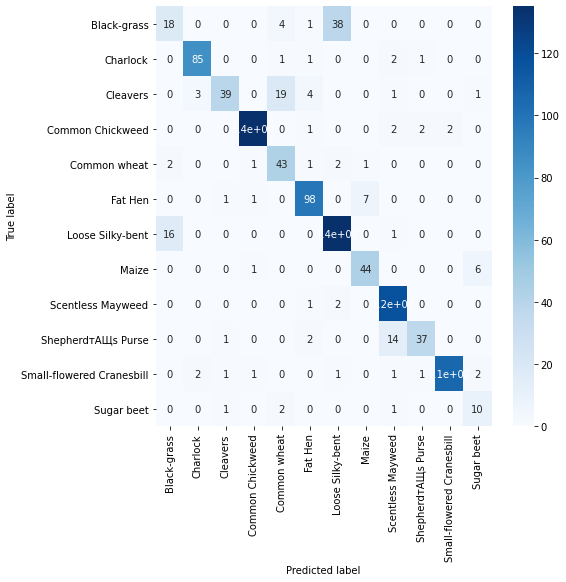

In [ ]:
confusion_mat_tfl = tf.math.confusion_matrix(labels=full_labels, predictions=pred_lite).numpy()
con_mat_df_tfl = pd.DataFrame(confusion_mat_tfl)

def confusion_matrix_plot(df):
  figure = plt.figure(figsize=(8, 8))
  sns.heatmap(df,
              annot=True,
              cmap=plt.cm.Blues,
              xticklabels=class_names,
              yticklabels=class_names)
  plt.tight_layout()
  plt.ylabel('True label')
  plt.xlabel('Predicted label')
  plt.show()

confusion_matrix_plot(con_mat_df_tfl)

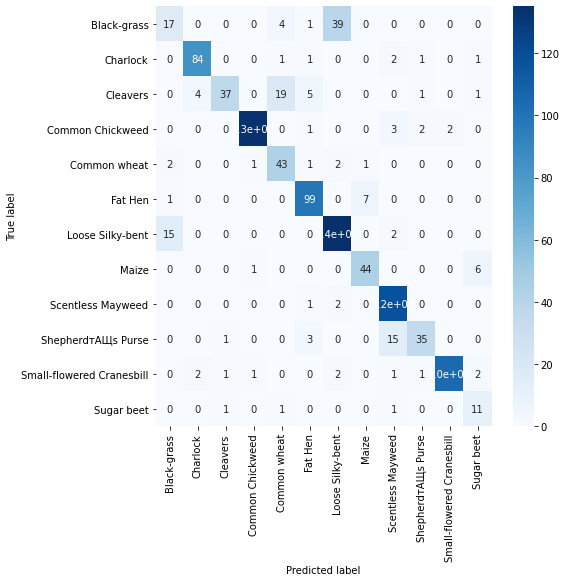

In [ ]:
confusion_mat_q = tf.math.confusion_matrix(labels=full_labels, predictions=pred_quant).numpy()
con_mat_df_q = pd.DataFrame(confusion_mat_q)

def confusion_matrix_plot(df):
  figure = plt.figure(figsize=(8, 8))
  sns.heatmap(df,
              annot=True,
              cmap=plt.cm.Blues,
              xticklabels=class_names,
              yticklabels=class_names)
  plt.tight_layout()
  plt.ylabel('True label')
  plt.xlabel('Predicted label')
  plt.show()

confusion_matrix_plot(con_mat_df_q)